In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.cloud import bigquery
bq = bigquery.Client()

In [2]:
%%bigquery
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.45s/rows]


,frac_delayed
0,0.186111


In [3]:
sql = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""
bq.query(sql).to_dataframe()

,frac_delayed
0,0.186111


In [4]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE DEP_DELAY >= 10

Downloading: 100%|██████████| 1294778/1294778 [00:01<00:00, 735878.96rows/s] 


In [5]:
type(df)
df.describe()

,ARR_DELAY,DEP_DELAY
count,1.286778e+06,1.294778e+06
mean,4.611797e+01,5.094516e+01
std,6.360700e+01,6.151423e+01
min,-7.800000e+01,1.000000e+01
25%,1.100000e+01,1.700000e+01
50%,2.700000e+01,3.000000e+01
75%,5.900000e+01,6.100000e+01
max,1.971000e+03,1.988000e+03


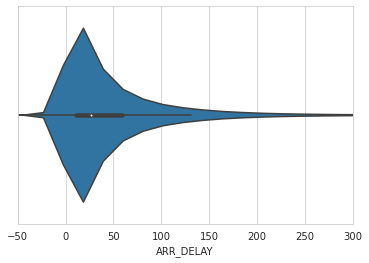

In [6]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')
ax.axes.set_xlim(-50, 300);

In [7]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr

Downloading: 100%|██████████| 5819079/5819079 [00:03<00:00, 1844829.57rows/s]


In [8]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

,ARR_DELAY,DEP_DELAY,ontime
2,33.0,48.0,False
3,126.0,126.0,False
4,34.0,25.0,False
5,41.0,32.0,False
6,43.0,43.0,False


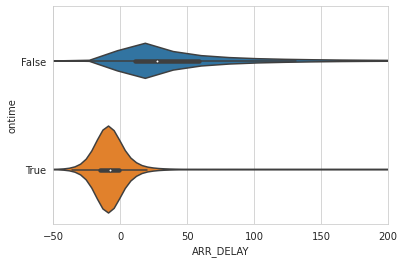

In [9]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200);

(-50.0, 200.0)

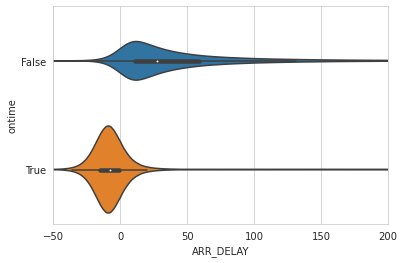

In [11]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

In [12]:
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (
    SELECT COUNT(*) FROM dsongcp.flights_tzcorr
);
CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64>
AS ((
    SELECT AS STRUCT
        THRESH,
        (NUM_TOTAL - SUM(numflights)) AS num_removed,
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2) AS lm
    FROM
    (
        SELECT
            DEP_DELAY,
            AVG(ARR_DELAY) AS arrival_delay,
            STDDEV(ARR_DELAY) AS stddev_arrival_delay,
            COUNT(ARR_DELAY) AS numflights
        FROM
            dsongcp.flights_tzcorr
        GROUP BY
            DEP_DELAY
    )
    WHERE numflights > THRESH
))
;
SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

Downloading: 100%|██████████| 9/9 [00:01<00:00,  7.00rows/s]


In [13]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

0    (1000, 175873, 0.25)
1     (500, 143801, 0.34)
2     (370, 135518, 0.36)
3     (300, 129835, 0.38)
4      (200, 123640, 0.4)
5     (100, 115471, 0.43)
6      (22, 108247, 0.45)
7      (10, 106958, 0.46)
8       (5, 106319, 0.46)
Name: stats, dtype: object

In [16]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

Downloading: 100%|██████████| 240/240 [00:01<00:00, 216.39rows/s]


In [15]:
depdelay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950
